Here, you develop the E+M Runge-Kuttas. (You want to be able to graph two functions at a time. The plotting functions can handle it, but the other functions aren't built for it specifically because your cases are simple enough that the answer for the B field is proportional to the E Field.)

In [1]:
import os.path
import numpy as np
import scipy as sp
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 16
refRatio = 2
CFL = np.sqrt(0.5)
ntC = 4
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 1
order = 1

L = 1
locs = [x_1]
epsilons = [1, 0.5] # [1, 1]
mus = [1, 0.5] # [1, 1]

func = WFT.Gauss # SquareWave
plotCont = True
enlarge = False

In [3]:
omegaC = BT.Grid(nh_min)
physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat
matIndC = physicsC.matInd
finepart = list(np.arange(matIndC - order, matIndC + order))

omegaAMR = BT.Grid(nh_min)
omegaAMR.AddPatch(refRatio, finepart)
physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
c = physicsAMR.cVec
cMatAMR = physicsAMR.cMat
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat


wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
nullspaceBlock = OT.Block(nullspace, var = 2)
restrictOp = GTT.CoarsenOp(omegaAMR)
restrictOpBlock = OT.Block(restrictOp, var = 2)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

In [4]:
cVecC = physicsC.cVec
c1 = cVecC[0]
c2 = cVecC[-1]

In [5]:
# mu, sigma = WFT.GaussParams(x_0, x_1)
sigma = 1. / 32.
mu = 0.25
args = [sigma, mu]

nt = int(2*ntC)
t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = nt)


In [6]:
def calcPhiAverage(phi_fn, x, dx, N):

    qloc = np.linspace(0, 1, num = 5)
    qweights = np.asarray([7, 32, 12, 32, 7])/90
    phiavg = np.zeros(N, float)
    for q in range(5):
        phiavg = phiavg + qweights[q]*phi_fn(x[:N]+dx*qloc[q])
    return phiavg

In [7]:
def momentMatrix(x, x0, h, ixs, P):
    ilo = min(ixs)
    ihi = max(ixs)
    xhi = (x[ilo+1:ihi+2] - x0)/h
    xlo = (x[ilo:ihi+1] - x0)/h
#     print('xhi:')
#     print(xhi)
#     print('xlo:')
#     print(xlo)
    A = np.zeros((np.shape(ixs)[0],P), float)
    for p in range(P):
#         print('p:', p)
#         print('A 1:')
#         print((xhi**(p+1))/(p+1))
        A[:,p] = (xhi**(p + 1) - xlo**(p + 1)) / ((p + 1) * (xhi - xlo))
    A = np.asarray(A)
    return A

In [8]:
# Fill in cell-average ghost cells using jump conditions

def ghostCellsJump(omega, physics, phiavg,Ng,P):
    
    dx = omega.h[0]
    xNode = omega.xNode
    matInd = physics.matInd
    loc = physics.locs[0]
    
#     print('My x:')
#     print(xNode[matInd-P:matInd+P+1] - loc)
    
    # Create the cell average interpolation matrix
    x = xNode[matInd-P:matInd+P+1] - loc # np.arange(-P, P + 1).transpose()*dx
#     print('Hans\' x:')
#     print(x)
    print('')
    x0 = 0
    ixs = np.arange(2*P).transpose()
    A = momentMatrix(x,x0,dx,ixs,P)

    # Build up an interpolant using the jump condition
    ix = np.arange(P)
    phi1 = phiavg[int(matInd-P)+ix] # phi avg in domain 1
    ix2 = np.arange(P)+P # domain 2 entries
    phi2 = phiavg[int(matInd-P)+ix2] # phi avg in domain 2
    B = OT.Block([A[ix,:], A[ix2,:]]) # add the fit to the matrix
    addOn = np.zeros(2 * P, float)
    addOn[0] = 1
    addOn[P] = -1
    
    # Add the jump cond constraint - constant coef is same at x=0
    B = np.vstack([B, addOn])
    
    # Solve it with LS
    phic = LA.pinv(B)@np.concatenate([phi1, phi2, np.zeros(1, float)])

    # Evaluate the phi1 ghost cell values
    ix = P+np.arange(Ng)
    phig1 = A[ix,:]@phic[:P]

    # Evaluate the phi2 ghost cell values
    ix = np.arange(P-Ng, P)
    phig2 = A[ix,:]@phic[P:2*P]
    
    return phig1, phig2

In [9]:
## Calculate the RHS for E,B in Maxwell's equations using 1st-order upwind
def CalcRHSUpwind1(omega, physics, u0):
    
    degFreed = omega.degFreed
    cs = physics.cVec
    matInd = physics.matInd
    
    c1 = cs[0]
    c2 = cs[-1]
    
    E = u0[:degFreed]
    B = u0[degFreed:]
    
    hMat = OT.StepMatrix(omega)
    
#     (E, B, c1, c2, N, dx):

    # Transform to the computational vars w/ eigen xform
    phil1 = .5*(E[:matInd]-c1*B[:matInd])
    phir1 = .5*(E[:matInd]+c1*B[:matInd])
    phil2 = .5*(E[matInd:]-c2*B[matInd:])
    phir2 = .5*(E[matInd:]+c2*B[matInd:])

    # Face values from upwind (index 1:N for faces left of cell + 1 for mat)
    phil1f = np.append(phil1, 0) # 0 placeholder for value with jump condition
    phir1f = np.append(0, phir1) # 0 at leftmost face for boundary conditions
    phil2f = np.append(phil2, 0) # 0 at rightmost face for boundary conditions
    phir2f = np.append(0, phir2)
    
    # Correct values at material interface with jump conditions
    T1 = 2*c1/(c1+c2)
    R1 = (c2-c1)/(c1+c2)
    phil1f[matInd] = T1*phil2f[0] + R1*phir1f[matInd]
    T2 = 2*c2/(c1+c2)
    R2 = (c1-c2)/(c1+c2)
    phir2f[0] = R2*phil2f[0] + T2*phir1f[matInd]

    # Transform back to E,B on faces
    E1f = phil1f + phir1f
    B1f = (-phil1f + phir1f)/c1
    E2f = phil2f + phir2f
    B2f = (-phil2f + phir2f)/c2

    # Calculate the RHS for E, B
    rhsE = hMat @ np.append(-c1**2*(B1f[1:] - B1f[:-1]), -c2**2*(B2f[1:] - B2f[:-1]))
    rhsB = hMat @ np.append(-1*(E1f[1:] - E1f[:-1]), -1*(E2f[1:] - E2f[:-1]))
    return rhsE, rhsB

In [10]:
## Calculate the RHS for E,B in Maxwell's equations using 5th-order upwind
def CalcRHSUpwind5(omega, physics, u0):
    
    degFreed = omega.degFreed
    cs = physics.cVec
    matInd = physics.matInd
    
    c1 = cs[0]
    c2 = cs[-1]
    
    E = u0[:degFreed]
    B = u0[degFreed:]
    
    hMat = OT.StepMatrix(omega)
    
    # Fill in ghost cells for left, right domain - need 3 for up5
    P = 5  # 5th-order interpolant
    Ng = 3  # 3 ghost cells for this stencil
    Eg1, Eg2 = ghostCellsJump(omega, physics, E, Ng, P)
#     print('Ghost Cells:')
#     print(Eg1)
#     print(Eg2)
#     print('')
    Bg1, Bg2 = ghostCellsJump(omega, physics, B, Ng, P)

    # Transform to the computational vars w/ eigen xform
    E1 = np.concatenate((E[:matInd], Eg1))  # with ghost cell values at the jump
    B1 = np.concatenate((B[:matInd], Bg1))
    phil1 = 0.5 * (E1 - c1 * B1)  # characteristic variable
    phir1 = 0.5 * (E1 + c1 * B1)
    E2 = np.concatenate((Eg2, E[matInd:]))  # with ghost cell values at the jump
    B2 = np.concatenate((Bg2, B[matInd:]))
    phil2 = 0.5 * (E2 - c2 * B2)
    phir2 = 0.5 * (E2 + c2 * B2)

    # Regular Face stencil from cell-averages - upwind for right-moving
    # [2 -13 47 | 27 -3]/60
    sr = np.array([2, -13, 47, 27, -3]) / 60
    Ni = matInd + 2 * Ng  # +3 ghost cells either side
    Ur = sp.sparse.diags(sr, np.arange(0, 5), shape=(matInd + 1, Ni))
    Ur = np.asarray(Ur.todense())

    sl = np.flip(sr)
    Ul = sp.sparse.diags(sl, np.arange(1, 6), shape=(matInd + 1, Ni))
    Ul = np.asarray(Ul.todense())
    
    print('Ur:')
    print(Ur)
    print('Ul:')
    print(Ul)
    print('phil1:')
    print(np.concatenate((np.full(Ng, phil1[0]), phil1)))

    # Face values from upwind (index 1:N for faces left of cell + 1 for mat)
#     phil1f = Ul.dot(np.concatenate((np.full(3, phil1[0]), phil1)))  # outflow bc's on left
    phil1f = Ul @ np.concatenate((np.full(Ng, phil1[0]), phil1))  # outflow bc's on left
    phir1f = Ur @ np.concatenate((np.zeros(Ng), phir1))  # 0 at leftmost face for inflow boundary conditions
#     phil2f = Ul.dot(np.concatenate((phil2, np.zeros(3))))  # 0 at rightmost face for inflow boundary conditions
    phil2f = Ul @ np.concatenate((phil2, np.zeros(Ng))).transpose()  # 0 at rightmost face for inflow boundary conditions
    phir2f = Ur @ np.concatenate((phir2, np.full(Ng, phir2[matInd + Ng - 1])))  # outflow bc's on right

    # Correct values at material interface with jump conditions
    T1 = 2 * c1 / (c1 + c2)
    R1 = (c2 - c1) / (c1 + c2)
    phil1f[matInd] = T1 * phil2f[0] + R1 * phir1f[matInd]
    T2 = 2 * c2 / (c1 + c2)
    R2 = (c1 - c2) / (c1 + c2)
    phir2f[0] = R2 * phil2f[0] + T2 * phir1f[matInd]

    # Transform back to E,B on faces
    E1f = phil1f + phir1f
    B1f = (-phil1f + phir1f) / c1
    E2f = phil2f + phir2f
    B2f = (-phil2f + phir2f) / c2

    # Calculate the RHS for E, B
    rhsE = hMat @ np.append(-c1**2*(B1f[1:] - B1f[:-1]), -c2**2*(B2f[1:] - B2f[:-1]))
    rhsB = hMat @ np.append(-1*(E1f[1:] - E1f[:-1]), -1*(E2f[1:] - E2f[:-1]))

    return rhsE, rhsB

In [11]:
# RK1 for a given rhs function
def ForwardEuler(omega, physics, u0, t, dt, fn_rhs):
    u = u0.copy()
    degFreed = omega.degFreed
    
    E = u[:degFreed]
    B = u[degFreed:]

    rhsE, rhsB = fn_rhs(omega, physics, u0)
    E = E + dt*rhsE
    B = B + dt*rhsB
    t = t + dt
    
    u = np.append(E, B)
    return u, t

In [12]:
def RungeKutta(omega, physics, u0, CFL, nt, RK, fn_rhs):
    u = u0.copy()
    
    cMat = physics.cMat
    dx, dt = ST.FindDxDt(omega, CFL, cMat)
    
    waves = WT.MakeWaves(omega)
    nullspace = OT.FindNullspace(omega, waves)
    waves = waves @ nullspace
    
    wavesBlock = OT.Block(waves, var = 2)
    
    errorMess = ''
    if (RK == 1):
        Scheme = ForwardEuler
    else:
        if (RK == 2):
            errorMess = str(RK) + ' is not a valid RK entry right now!'
#             Scheme = MidpointMeth
        else:
            if (RK == 4):
                errorMess = str(RK) + ' is not a valid RK entry right now!'
#                 Scheme = RK4
            else:
                errorMess = str(RK) + ' is not a valid RK entry!'
            
    if (errorMess != ''):
        sys.exit(errorMess)
    
    t = 0
    for n in range(nt):
        u, t = Scheme(omega, physics, u, t, dt, fn_rhs)
        print('n:', n)
        print(u)
        print('')
    uCoefs = LA.inv(wavesBlock) @ u
    
    return uCoefs

In [13]:
fn_rhs = CalcRHSUpwind5

In [14]:
# Initialize waves.

phi_fn = lambda x: exp(-((x-mu)/sigma)**2)
xC = omegaC.xNode
xF = omegaF.xNode
dxC = omegaC.h[0]
dxF = omegaF.h[0]
EC = calcPhiAverage(phi_fn, xC, dxC, nh_min) # WFT.InitCond(omega, physics, func, args, field = 'E')
EC[abs(EC) < 1e-15] = 0
BC = EC / c1
waveInitC = np.append(EC, BC)
EF = calcPhiAverage(phi_fn, xF, dxF, nh_max) # WFT.InitCond(omega, physics, func, args, field = 'E')
EF[abs(EF) < 1e-15] = 0
BF = EF / c1
waveInitF = np.append(EF, BF)

# waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
# waveInitF = WFT.InitCond(omegaF, physicsF, func, args)
waveInitAMR = restrictOpBlock @ waveInitF

# Find Fourier coefficients of initialized waves.
FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)

# Propagate analytic solutions.
wavePropC = WFT.WaveEq(omegaC, physicsC, func, args, t)
wavePropF = WFT.WaveEq(omegaF, physicsC, func, args, t)
wavePropAMR = WFT.WaveEq(omegaAMR, physicsC, func, args, t)

# Find Fourier coefficients of propagated solutions.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC)
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF)
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

#
solverCoefsC = RungeKutta(omegaC, physicsC, waveInitC, CFL, ntC, RK, fn_rhs)
solverCoefsF = RungeKutta(omegaF, physicsF, waveInitF, CFL, nt, RK, fn_rhs)
solverCoefsAMR = RungeKutta(omegaAMR, physicsAMR, waveInitAMR, CFL, nt, RK, fn_rhs)

# Load up Fourier coefficients.
allCoefsC = PT.Load(FCoefsC, FCoefsPropC, solverCoefsC)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF, solverCoefsF)
allCoefsAMR = nullspaceBlock @ PT.Load(FCoefsAMR, FCoefsPropAMR, solverCoefsAMR)

labels = ['Initial Wave', 'Analytically Propagated Wave', 'RK Propagated Wave']



Ur:
[[ 0.03333333 -0.21666667  0.78333333  0.45       -0.05        0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03333333 -0.21666667  0.78333333  0.45       -0.05        0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.03333333 -0.21666667  0.78333333  0.45       -0.05        0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.03333333 -0.21666667  0.78333333  0.45       -0.05        0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.03333333 -0.21666667  0.78333333  0.45       -0.05        0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.03333333 -0.21666667  0.78333333  0.45       -0.05        0.          0.  

Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?


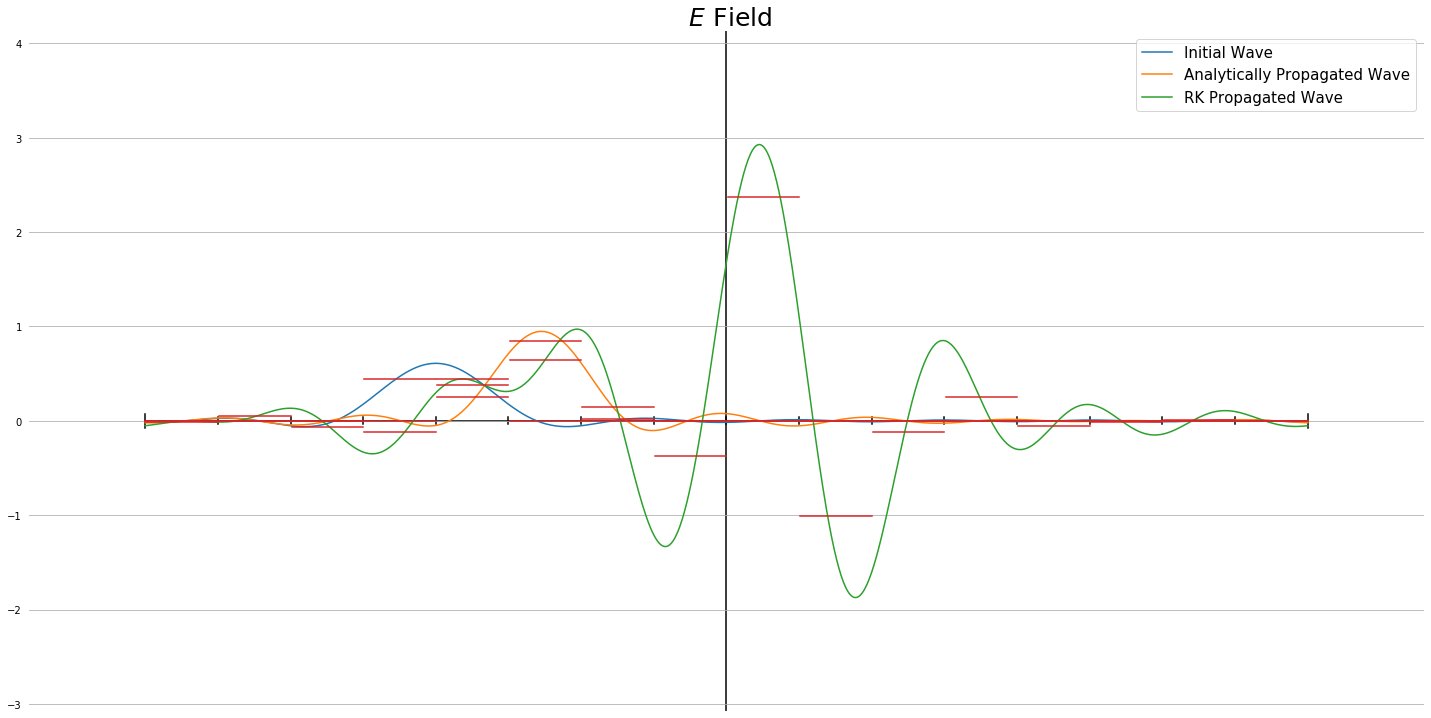

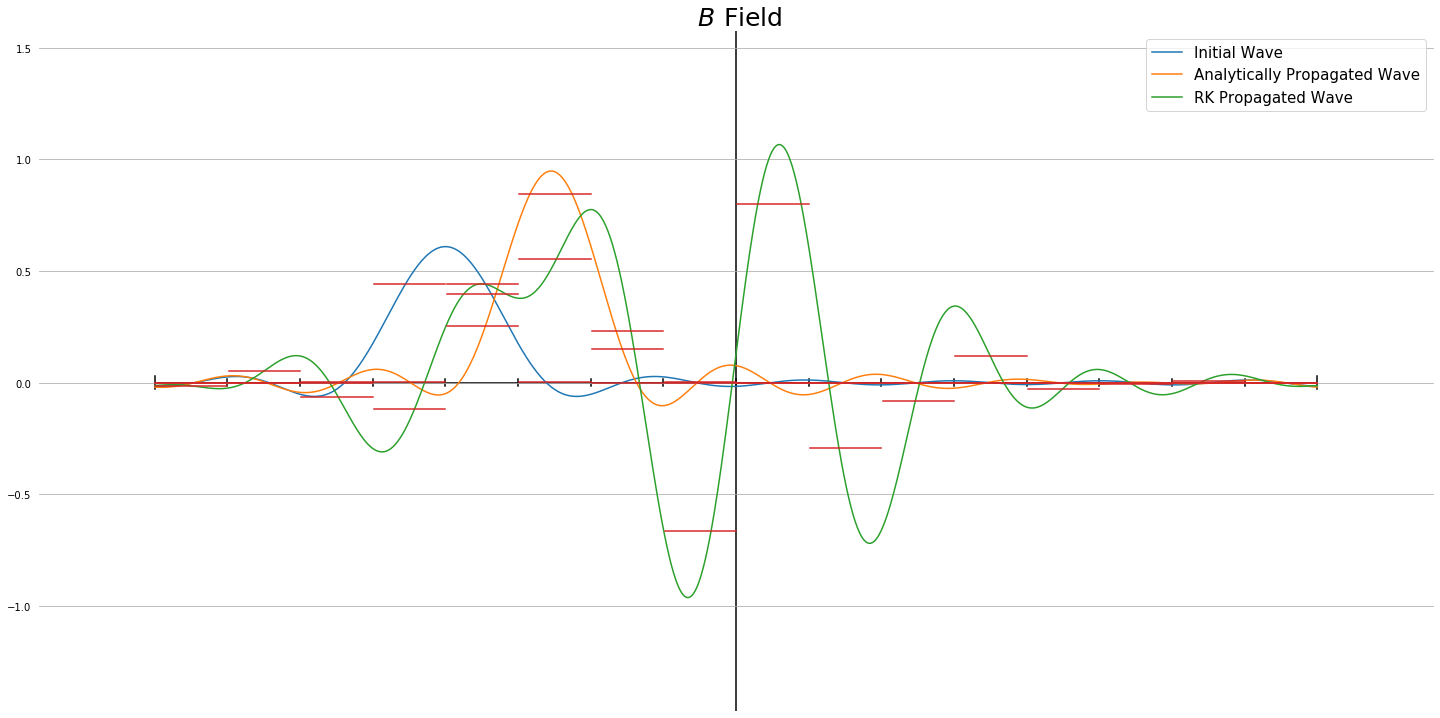

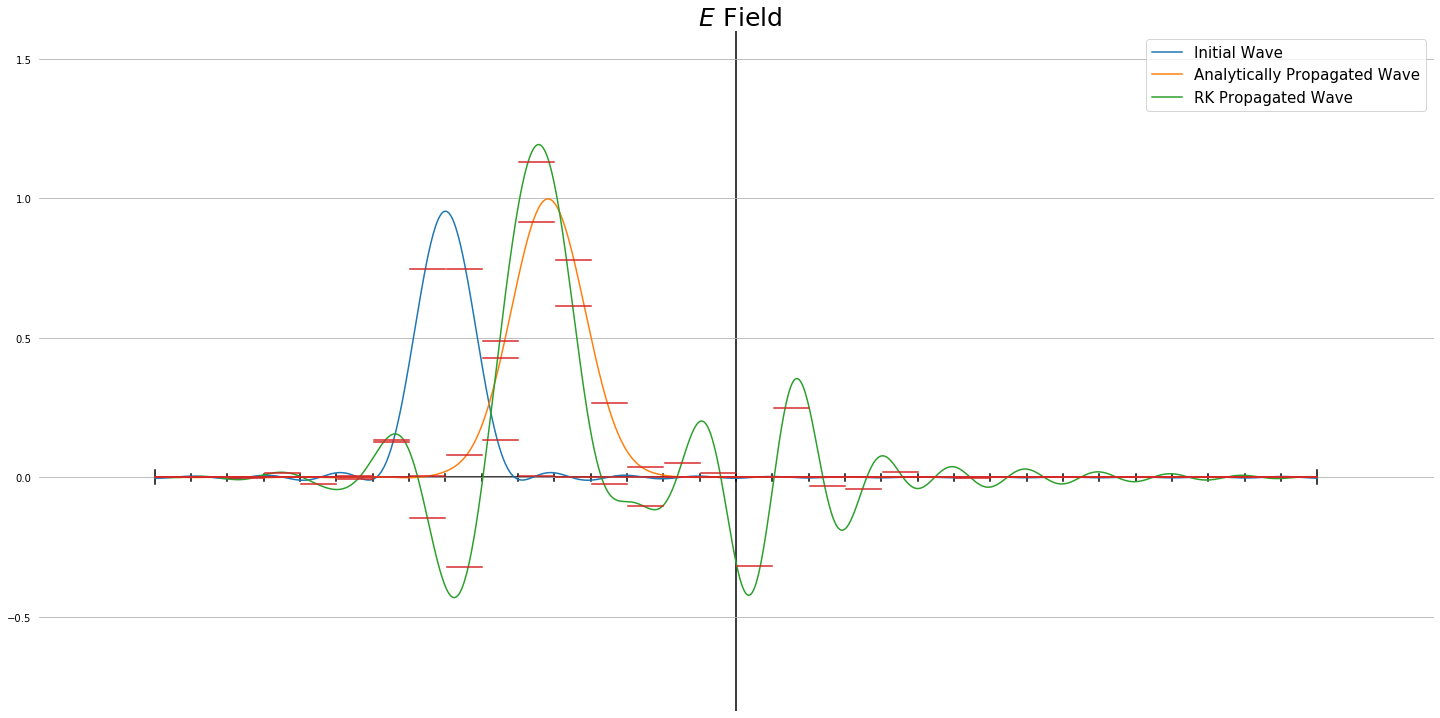

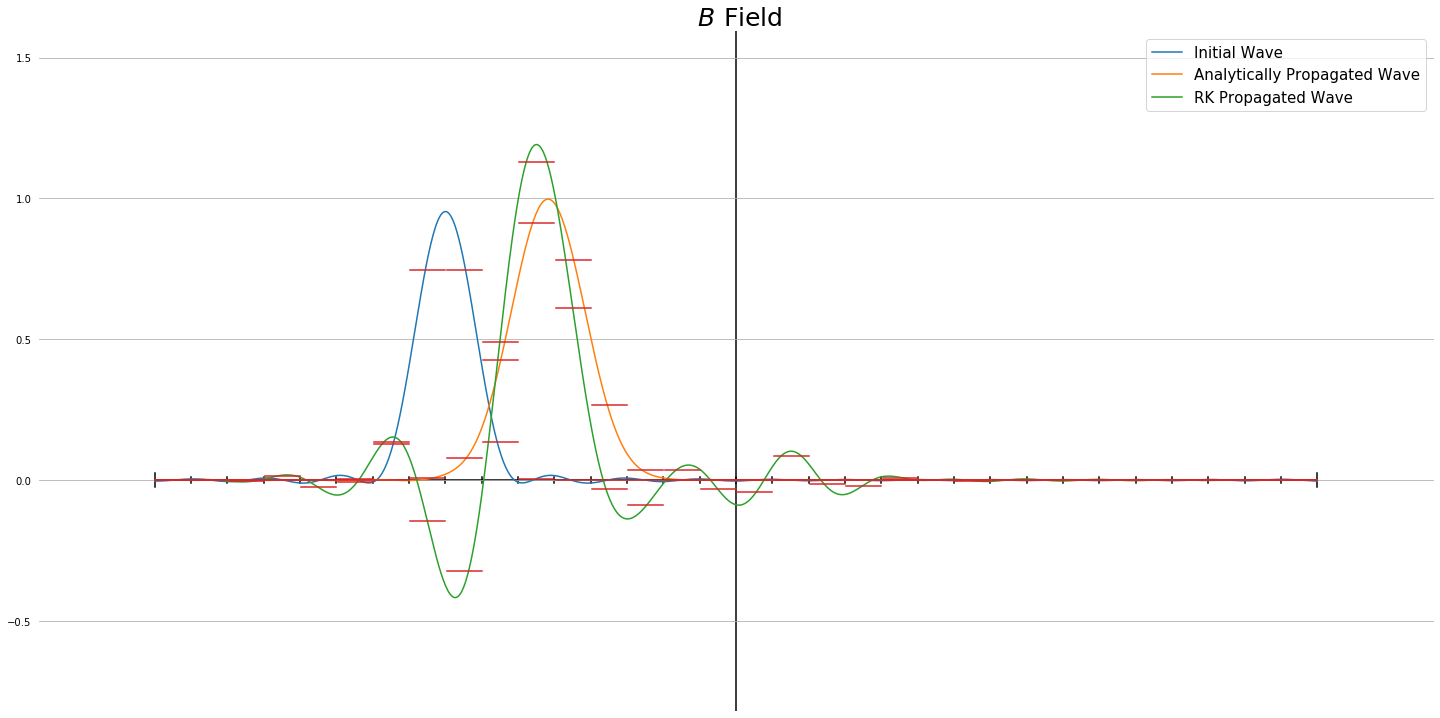

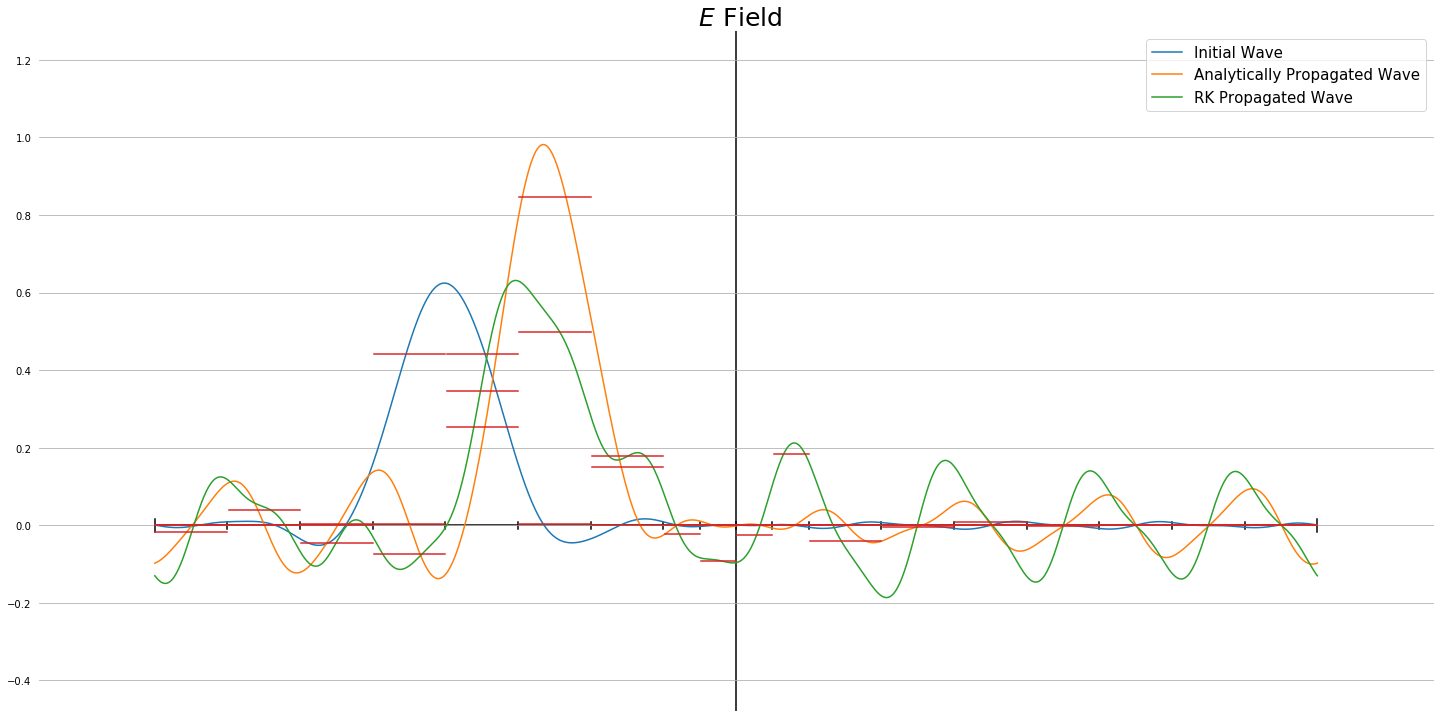

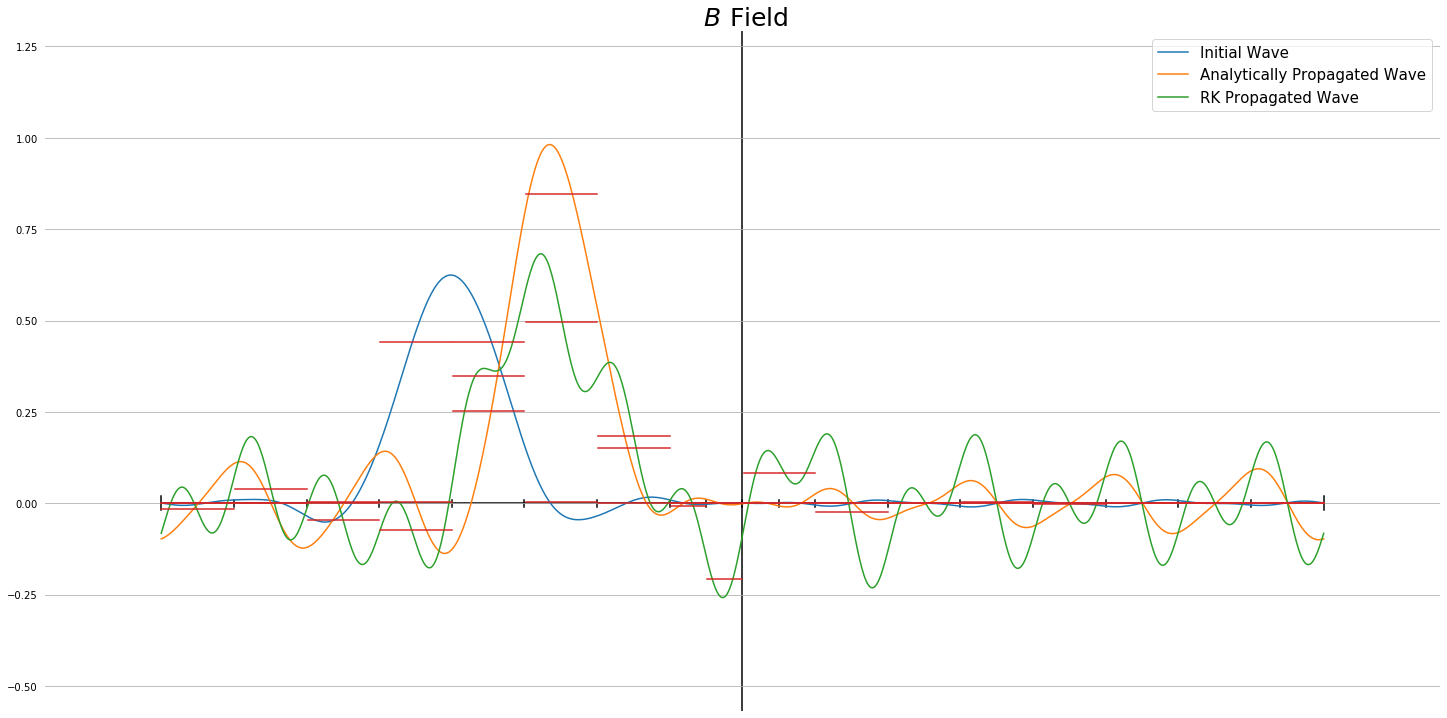

In [15]:
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, plotCont = plotCont, enlarge = enlarge)#, saveName = 'RKWaveEqAttempt2')#, saveName = 'Coarse', dpi = 300)
PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, enlarge = enlarge, plotCont = plotCont)#, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True, labels = labels, enlarge = enlarge, plotCont = plotCont)#, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [16]:
matInd = physicsC.matInd
x = omegaC.xCell
print(matInd)
print(x[:matInd])
print(x[matInd:])
print(x[matInd-1])
print('')

8
[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875]
[0.53125 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
0.46875



In [17]:
A = np.arange(10)
print(A)
print(A[1:])
print(A[:-1])
print('')

[0 1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8]



In [18]:
[ 3.82866694e-01 -4.98793618e-01 -1.32577224e+00  2.07251375e+00  6.26118627e-01 -3.85573235e+01  7.20580429e+01  6.70893025e+02 -2.88217129e+03  7.30524335e+01 -1.03173805e+01  3.96466149e-01 -3.08645462e-02  8.60248300e-04 -3.55192724e-05 -2.95544601e-07  3.83614754e-01 -5.11553588e-01 -1.12535267e+00  2.43898307e+00  3.62602686e+00 -4.65548909e+01  9.59038806e+01  1.34158479e+03 -1.42647089e+03  3.65834876e+01 -5.15854548e+00  1.98232576e-01 -1.54322731e-02  4.30124150e-04 -1.77596362e-05 -1.47772300e-07]
[-1.64351566e-02  5.12886593e-02 -6.32571735e-02 -1.22501573e-01  3.82130956e-01  6.46922800e-01  2.14696272e-02 -3.73901749e-01  2.37764045e+00 -1.00346714e+00 -1.16892814e-01  2.49027222e-01 -5.76708467e-02 -1.51868443e-02  1.33830339e-02 -4.42255615e-03 -1.64674459e-02  5.16223746e-02 -6.47974228e-02 -1.19838179e-01  3.95581047e-01  5.55061166e-01  2.31013005e-01 -6.62892652e-01  8.02112951e-01 -2.92142992e-01 -8.28269959e-02  1.20028954e-01 -2.69840199e-02 -7.85152568e-03  6.70943847e-03 -2.21177681e-03]
[-0.01643516      0.05128866     -0.06325717     -0.12250157      0.38213096      0.6469228       0.02146963     -0.37390175      2.37764045     -1.00346714     -0.11689281      0.24902722     -0.05767085     -0.01518684      0.01338303     -0.00442256     -0.01646745      0.05162237     -0.06479742     -0.11983818      0.39558105      0.55506117      0.23101301     -0.66289265      0.80211295     -0.29214299     -0.082827        0.12002895     -0.02698402     -0.00785153      0.00670944     -0.00221178]



SyntaxError: invalid syntax (<ipython-input-18-4fcb9e23e070>, line 1)